# Web Scraping

In [1]:
from dotenv import load_dotenv
load_dotenv("dev.env")
import os

db_name = os.getenv("db_name")
db_username = os.getenv("db_username")
db_password = os.getenv("db_password")
db_host = os.getenv("db_host")
db_port = os.getenv("db_port")
website = os.getenv("website")
city_link = os.getenv("city_link")
chrome_path = os.getenv("chrome_path")
selenium_chrome_driver_path = os.getenv("selenium_chrome_driver_path")

First, we are loading environment variables, this is not required for non-professional projects but it is a good practice to hide your private variables that contains database credentials which might make your server vulnerable.

In [2]:
import psycopg2
import time
import math
import numpy as np
import os.path
import pandas as pd
import re
import pycld2
import nltk
import joblib
import warnings
import urllib.request
import io
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
import sys
from datetime import date, timedelta, datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
from PIL import Image
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from sklearn import metrics
from sklearn.utils import shuffle
#from IPython.display import display, Image

nltk.download('stopwords', quiet=True)

stemmer = TurkishStemmer()

conn_string = 'host={pghost} port={pgport} dbname={pgdatabase} user={pguser} password={pgpassword}'.format(pgdatabase=db_name,pguser=db_username,pgpassword=db_password,pghost=db_host,pgport=db_port)
conn=psycopg2.connect(conn_string)
cur=conn.cursor()

options = Options()
options.binary_location = chrome_path

warnings.filterwarnings('ignore')

def check_if_table_exists(schema,table):
    cur.execute("select exists(select * from information_schema.tables where table_schema='{schema}' AND table_name='{table}')".format(schema=schema, table=table))
    return cur.fetchone()[0]

def check_if_index_exists(index):
    cur.execute("SELECT EXISTS(SELECT * FROM PG_CLASS WHERE relname = '{index}')".format(index=index))
    return cur.fetchone()[0]

def check_if_file_exists(filename):
    return os.path.isfile(filename)

def execute_mogrify(conn, df, schema, table):
    tuples = [tuple(x) for x in df.to_numpy()]
    cols = '"'+'","'.join(list(df.columns))+'"'
    cursor = conn.cursor()    
    try:
        for tup in tuples:
            query  = """INSERT INTO "{schema}"."{table}"({cols}) VALUES ({values}) ON CONFLICT DO NOTHING""".format(schema=schema,table=table, cols=cols, values=",".join(map(str,tup)))
            cursor.execute(query)
            conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

def df_column_conversation(df, column_name, type):
    if(type == 'timestamp'):
        df[column_name] = df[column_name].apply(lambda x: f"'{x}'::timestamp")
    if(type == 'text'):
        df[column_name] = df[column_name].str.replace("'","").apply(lambda x: f"'{x}'")
    if(type == 'date'):
        df[column_name] = df[column_name].apply(lambda x: f"'{x}'::date")
    if(type == 'numeric'):
        df[column_name] = df[column_name].apply(str).str.replace(',','.')
    if(type == 'integer'):
        df[column_name] = df[column_name].apply(str).str.replace(',','.').apply(float).astype('Int64').apply(str)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-\\]", "", text)
    return text

def webpage_scroll_down(driver, scroll_speed):
    total_height = int(driver.execute_script("return document.body.scrollHeight"))
    for i in range(1, total_height, scroll_speed):
        driver.execute_script("window.scrollTo(0, {});".format(i))

def byte_image_to_numpy_array(byte_image, image_size):
    return cv2.resize(np.array(Image.open(io.BytesIO(byte_image))), (image_size, image_size))

We are defining our functions and importing libraries which will be used in the next steps.

In [3]:
if(check_if_table_exists('ODS','EXT_FB_RESTAURANT')):
    print('Table ODS.EXT_FB_RESTAURANT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_RESTAURANT"
    (
    "RESTAURANT_ID" text NOT NULL,
    "RESTAURANT_NAME" text,
    "RESTAURANT_LINK" text,
    "DATE" date,    
    CONSTRAINT "RESTAURANT_ID" UNIQUE ("RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_RESTAURANT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_MENU')):
    print('Table ODS.EXT_FB_MENU already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_MENU"
    (
    "PRODUCT_ID" text NOT NULL,
    "RESTAURANT_ID" text,
    "CATEGORY_NAME" text,
    "PRODUCT_NAME" text,
    "PRODUCT_DESCRIPTION" text,
    "PRODUCT_LISTED_PRICE" text,
    "PRODUCT_PRICE" text,
    "DISCOUNT" boolean,
    "DESIGN_TYPE" text,
    "DATE" date,
    CONSTRAINT "PRODUCT_ID" UNIQUE ("PRODUCT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_MENU created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_COMMENT')):
    print('Table ODS.EXT_FB_COMMENT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_COMMENT"
    (
    "RESTAURANT_ID" text,
    "USERNAME" text,
    "COMMENT_TEXT" text,
    "COMMENT_DATE" text,
    "SPEED" text,
    "SERVING" text,
    "FLAVOUR" text,
    "DATE" date,
    CONSTRAINT "UNIQUE_COMMENTS" UNIQUE ("RESTAURANT_ID", "USERNAME", "COMMENT_TEXT")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_COMMENT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_PRODUCT_IMAGE')):
    print('Table ODS.EXT_FB_PRODUCT_IMAGE already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_PRODUCT_IMAGE"
    (
    "PRODUCT_ID" text,
    "RESTAURANT_ID" text,
    "IMAGE_LINK" text,
    "DATE" date,
    CONSTRAINT "UNIQUE_IMAGES" UNIQUE ("PRODUCT_ID", "RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_PRODUCT_IMAGE created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_PRODUCT_IMAGE_SOURCE')):
    print('Table ODS.EXT_FB_PRODUCT_IMAGE_SOURCE already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE"
    (
    "IMAGE_LINK" text NOT NULL,
    "SOURCE" bytea,
    CONSTRAINT "UNIQUE_SOURCE" PRIMARY KEY ("IMAGE_LINK")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_PRODUCT_IMAGE_SOURCE created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('EDW','DWH_FB_COMMENT')):
    print('Table EDW.DWH_FB_COMMENT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_FB_COMMENT"
    (
    "RESTAURANT_ID" text,
    "USERNAME" text,
    "COMMENT_TEXT" text,
    "COMMENT_DATE" date,
    "SPEED" integer,
    "SERVING" integer,
    "FLAVOUR" integer,
    "DATE" date,
    CONSTRAINT "UNIQUE_COMMENTS" UNIQUE ("RESTAURANT_ID", "USERNAME", "COMMENT_TEXT")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table EDW.DWH_FB_COMMENT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

cur.execute("""
CREATE OR REPLACE FUNCTION public.try_cast(_in text, INOUT _out anyelement)
    LANGUAGE 'plpgsql'
AS $BODY$
BEGIN
   EXECUTE format('SELECT %L::%s', $1, pg_typeof(_out))
   INTO  _out;
EXCEPTION WHEN others THEN
   -- do nothing: _out already carries default
END
$BODY$;
""")
cur.execute('COMMIT;')

Table ODS.EXT_FB_RESTAURANT already exists.
Table ODS.EXT_FB_MENU already exists.
Table ODS.EXT_FB_COMMENT already exists.
Table ODS.EXT_FB_PRODUCT_IMAGE already exists.
Table ODS.EXT_FB_PRODUCT_IMAGE_SOURCE already exists.
Table EDW.DWH_FB_COMMENT already exists.


Creating tables that will contain our data and creating database functions.

In [4]:
cur.execute("""
WITH DATES AS(
SELECT 
MAX("DATE") AS "DATE"
FROM "ODS"."EXT_FB_MENU" EFM
UNION ALL
SELECT 
MAX("DATE") AS "DATE"
FROM "ODS"."EXT_FB_COMMENT" EFC
)
SELECT 
MAX("DATE") AS "LAST_EXECUTION_DATE"
FROM DATES;
""")
last_execution_date = cur.fetchone()[0]
last_execution_date

datetime.date(2021, 6, 11)

Getting last execution dates in the tables to not import the same data we collected for performance.

In [5]:
restaurant_list = []
end_date = min(date(2021,6,11),(date.today() - timedelta(days=1)))

driver = webdriver.Chrome(options=options, executable_path=selenium_chrome_driver_path)
if(last_execution_date < end_date):
    driver.get(city_link)
    time.sleep(5)
    for i in range(25):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
    city_restaurant_groups = driver.find_elements_by_class_name("restaurant-main-info")
    for restaurant in city_restaurant_groups:
        restaurant_name = restaurant.find_element_by_class_name("restaurant-display-name").text
        restaurant_name = restaurant_name.replace("YENİ ", "")
        restaurant_link = restaurant.find_element_by_class_name("restaurant-display-name").find_element_by_xpath(".//a").get_attribute('href')
        restaurant_id = restaurant_link.split("/")[-1]
        if(len(restaurant_link) < 2):
            continue
        restaurant_list.append([restaurant_id,restaurant_name,restaurant_link])
    restaurant_df = pd.DataFrame(restaurant_list, columns=["RESTAURANT_ID","RESTAURANT_NAME","RESTAURANT_LINK"])

    df_column_conversation(restaurant_df, 'RESTAURANT_ID', 'text')
    df_column_conversation(restaurant_df, 'RESTAURANT_NAME', 'text')
    df_column_conversation(restaurant_df, 'RESTAURANT_LINK', 'text')    
    restaurant_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
    execute_mogrify(conn,restaurant_df,"ODS","EXT_FB_RESTAURANT")

Scraping the website to gather restaurant lists and their links, in this part we need to scroll down to load all the restaurants.

In [6]:
sql_command = """
    SELECT
    "RESTAURANT_ID"
    FROM "ODS"."EXT_FB_RESTAURANT" EFR
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_MENU" EFM WHERE EFR."RESTAURANT_ID" = EFM."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)

In [7]:
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        restaurant_link = "{website}/{sublink}".format(website=website,sublink=sublink)
        
        driver.get(restaurant_link)
        time.sleep(5)

        try:
            if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                continue
            else:
                pass
        except Exception:
            pass
        
        menu = driver.find_element_by_xpath('//*[@id="restaurant_menu"]')
        categories = menu.find_elements_by_xpath('//*[contains(@id,"menu_")]')

        menu_list = []

        for category in categories:
            category_name = category.find_element_by_xpath(".//b").text
            for product in category.find_elements_by_xpath(".//div[2]/ul/li"):
                try:
                    design_type = "list"
                    try:
                        product_id = product.find_elements_by_class_name("getProductDetail")[-1].get_attribute('data-product-id')
                        product_name = product.find_elements_by_class_name("getProductDetail")[-1].text
                    except:
                        product_id = product.find_element_by_xpath(".//strong").get_attribute('data-product-id')
                        product_name = product.find_element_by_xpath(".//strong").text
                        design_type = "card"
                    try:
                        product_description = product.find_element_by_class_name("product-desc").text
                        product_price = product.find_element_by_class_name("price").text    
                    except:
                        product_description = product.find_element_by_class_name("productInfo").text
                        product_price = product.find_element_by_class_name("newPrice").text
                        if(not(design_type=="card")):
                            design_type = "box"
                    discount = "TRUE"
                    try:              
                        if(design_type=="list"):
                            product_listed_price = product.find_element_by_class_name("listed-price").text
                        if(design_type in ["card","box"]):
                            product_listed_price = product.find_element_by_class_name("listedPrice").text
                    except:
                        product_listed_price = product_price
                        discount = "FALSE"
                    menu_list.append([product_id,sublink,category_name,product_name,product_description,product_listed_price,product_price,discount,design_type])
                except:
                    continue
        menu_df = pd.DataFrame(menu_list, columns=["PRODUCT_ID","RESTAURANT_ID","CATEGORY_NAME","PRODUCT_NAME","PRODUCT_DESCRIPTION","PRODUCT_LISTED_PRICE","PRODUCT_PRICE","DISCOUNT","DESIGN_TYPE"])    
        menu_df = menu_df[menu_df['PRODUCT_ID'].str.len() > 0]
        menu_df = menu_df[menu_df['PRODUCT_NAME'].str.len() > 0]

        df_column_conversation(menu_df, 'PRODUCT_ID', 'text')
        df_column_conversation(menu_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(menu_df, 'CATEGORY_NAME', 'text')
        df_column_conversation(menu_df, 'PRODUCT_NAME', 'text')
        df_column_conversation(menu_df, 'PRODUCT_DESCRIPTION', 'text')
        df_column_conversation(menu_df, 'PRODUCT_LISTED_PRICE', 'text')
        df_column_conversation(menu_df, 'PRODUCT_PRICE', 'text')
        df_column_conversation(menu_df, 'DESIGN_TYPE', 'text')
        menu_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,menu_df,"ODS","EXT_FB_MENU")
    menu_df

Looping through all of the restaurants and scraping their products.

In [8]:
sql_command = """
    SELECT
    "RESTAURANT_ID"
    FROM "ODS"."EXT_FB_RESTAURANT" EFR
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_COMMENT" EFC WHERE EFR."RESTAURANT_ID" = EFC."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df = restaurant_df.sample(frac=1)
restaurant_df

,RESTAURANT_ID
2,mandalin-mercan-tuzla-postane-mah-istanbul
63,mirall-cafe-restaurant-kadikoy-suadiye-mah-sas...
20,kervan-pide-lahmacun-sisli-izzet-pasa-mah-ista...
35,boysan-pizza-esenyurt-mehtercesme-mah-istanbul
11,konak-borek-pide-pizza-bagcilar-cinar-mah-ista...
...,...
27,cali-kahvesi-uskudar-murat-reis-mah-istanbul
9,fonseca-pizza-besiktas-dikilitas-mah-istanbul
25,sembol-pasta-pide-pizza-esenler-menderes-mah-i...
53,creme-cafe-bakery-sisli-tesvikiye-mah-istanbul


In [9]:
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        last_comment_page_url = "{website}/{sublink}?section=comments&page=9999".format(website=website,sublink=sublink)
        
        driver.get(last_comment_page_url)
        time.sleep(0.1)

        comments_list = []
        
        if(sublink not in driver.current_url):
            continue

        last_comment_page_redirect_url = driver.current_url
        last_comment_page_number = int(last_comment_page_redirect_url.replace("&status=closed","").replace("{website}/{sublink}?section=comments&page=".format(website=website,sublink=sublink),""))

        for page_number in range(1, last_comment_page_number+1):
            current_comment_page_url = "{website}/{sublink}?section=comments&page={page_number}".format(website=website,sublink=sublink,page_number=page_number)
            driver.get(current_comment_page_url)
            time.sleep(1)

            try:
                if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                    continue
                else:
                    pass
            except Exception:
                pass

            try:
                driver.find_element(By.XPATH, '//*[@id="alternative-restaurant-popup"]/div[1]/div[2]/img').click(); #Closing pop-up
            except Exception:
                pass   

            #driver.find_element(By.XPATH, '//*[@id="restaurantDetail"]/div[2]/div[1]/ul/li[4]/a').click(); #Clicking comments

            comment_list = driver.find_elements_by_class_name("comments-body")
        
            for comment in comment_list:
                try:
                    username = comment.find_element_by_class_name("userName").text
                    comment_text = comment.find_element_by_xpath('.//p').text
                    comment_date = comment.find_element_by_class_name("commentDate").text
                except NoSuchElementException:
                    continue
                try:
                    speed = comment.find_element_by_class_name("speed").text
                except NoSuchElementException:
                    speed = ""
                try:                    
                    serving = comment.find_element_by_class_name("serving").text
                except NoSuchElementException:
                    serving = ""
                try:
                    flavour = comment.find_element_by_class_name("flavour").text 
                except NoSuchElementException:
                    flavour = ""
                comments_list.append([sublink, username, comment_text, comment_date, speed, serving, flavour])
        comment_df = pd.DataFrame(comments_list, columns=["RESTAURANT_ID","USERNAME","COMMENT_TEXT","COMMENT_DATE","SPEED","SERVING","FLAVOUR"])
        df_column_conversation(comment_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(comment_df, 'USERNAME', 'text')
        df_column_conversation(comment_df, 'COMMENT_TEXT', 'text')
        df_column_conversation(comment_df, 'COMMENT_DATE', 'text')
        df_column_conversation(comment_df, 'SPEED', 'text')
        df_column_conversation(comment_df, 'SERVING', 'text')
        df_column_conversation(comment_df, 'FLAVOUR', 'text')
        comment_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,comment_df,"ODS","EXT_FB_COMMENT")
    comment_df

Looping through all of the restaurants and scraping their reviews and given scores for each comment.

In [10]:
sql_command = """
    SELECT DISTINCT 
    "RESTAURANT_ID",
    "DESIGN_TYPE"
    FROM "ODS"."EXT_FB_MENU" EFM
    WHERE 1=1
    AND EFM."DESIGN_TYPE" <> 'list'
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_PRODUCT_IMAGE" EFPI WHERE EFM."RESTAURANT_ID" = EFPI."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df

,RESTAURANT_ID,DESIGN_TYPE
0,the-boss-pizza-burger-sariyer-maden-mah-istanbul,card
1,444-pizza-bagcilar-demirkapi-mah-istanbul,card
2,mezzaluna-paket-beykoz-acarlar-mah-acarkent-is...,card
3,kafein-plus-kucukcekmece-tevfikbey-mah-sefakoy...,card
4,mayk-cafe-sisli-fulya-mah-istanbul,card
...,...,...
208,amigos-burger-pizza-kagithane-merkez-mah-istanbul,card
209,konak-firin-avcilar-merkez-mah-istanbul,card
210,keyifle-pide-lahmacun-bakirkoy-atakoy-6-kisim-...,card
211,havelka-kadikoy-caddebostan-mah-istanbul,card


In [11]:
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        design_type = restaurant_df.loc[i,"DESIGN_TYPE"]
        page_url = "{website}/{sublink}".format(website=website,sublink=sublink)

        driver.get(page_url)
        time.sleep(0.1)
        
        webpage_scroll_down(driver, 15)

        if(sublink not in driver.current_url):
                continue

        try:
            if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                continue
            else:
                pass
        except Exception:
            pass

        try:
            driver.find_element(By.XPATH, '//*[@id="alternative-restaurant-popup"]/div[1]/div[2]/img').click(); #Closing pop-up
        except Exception:
            pass

        menu = driver.find_element_by_xpath('//*[@id="restaurant_menu"]')
        categories = menu.find_elements_by_xpath('//*[contains(@id,"menu_")]')

        image_list = []

        for product in menu.find_elements_by_class_name("product-image"):
            try:
                product_id = product.get_attribute('data-product-id')
                image_link = product.find_element_by_xpath(".//img").get_attribute('src')
                if("www.yemeksepeti.com/assets/images/" in image_link):
                    continue
                image_list.append([product_id,sublink,image_link])
            except:
                pass
        image_df = pd.DataFrame(image_list, columns=["PRODUCT_ID","RESTAURANT_ID","IMAGE_LINK"])
        df_column_conversation(image_df, 'PRODUCT_ID', 'text')
        df_column_conversation(image_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(image_df, 'IMAGE_LINK', 'text')    
        image_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,image_df,"ODS","EXT_FB_PRODUCT_IMAGE")

In [12]:
driver.quit()

In [13]:
sql_command = """
    SELECT DISTINCT
    "IMAGE_LINK"
    FROM "ODS"."EXT_FB_PRODUCT_IMAGE" EFPI
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE" EFPIS WHERE EFPIS."IMAGE_LINK" = EFPI."IMAGE_LINK");
    """
image_df = pd.read_sql(sql_command,conn)
image_df = image_df.sample(frac=1).reset_index(drop=True)
image_df

,IMAGE_LINK
0,https://cdn.yemeksepeti.com/ProductImages/TR_I...


In [14]:
for i in range(len(image_df)):
    page_url = image_df.loc[i,"IMAGE_LINK"]
    image_file_name = "images/product.jpg"
    try:
        urllib.request.urlretrieve(page_url, image_file_name)
    except:
        continue
    image_binary = psycopg2.Binary(open(image_file_name, 'rb').read())
    cur.execute("""
    INSERT INTO "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE" ("IMAGE_LINK","SOURCE") 
    VALUES('{image_link}',{image_binary})
    ON CONFLICT DO NOTHING;
    """.format(image_link=page_url, image_binary=image_binary))
    cur.execute('COMMIT;')

Looping through all of the restaurants and scraping their product images for deep learning purposes.

# Data Preprocessing

In [15]:
if(last_execution_date < end_date):
    sql_command = """
        WITH CLEAN_DATA AS(
        SELECT
        EFC."RESTAURANT_ID",
        EFC."USERNAME",
        LOWER(EFC."COMMENT_TEXT") AS "COMMENT_TEXT",
        EFC."COMMENT_DATE",
        TRY_CAST(REGEXP_REPLACE(EFC."SPEED", '\D','','g'),NULL::INTEGER) AS "SPEED",
        TRY_CAST(REGEXP_REPLACE(EFC."SERVING", '\D','','g'),NULL::INTEGER) AS "SERVING",
        TRY_CAST(REGEXP_REPLACE(EFC."FLAVOUR", '\D','','g'),NULL::INTEGER) AS "FLAVOUR",
        EFC."DATE",
        REGEXP_REPLACE(EFC."COMMENT_DATE", '\D','','g')||' '||REPLACE(REPLACE(REPLACE(REGEXP_REPLACE(REPLACE(EFC."COMMENT_DATE",' önce',''), '[^[:alpha:]]', '', 'g'),'ay','month'),'bugün','today'),'gün','day') AS "COMMENT_DATE_INTERVAL"
        FROM "ODS"."EXT_FB_COMMENT" EFC
        WHERE 1=1
        AND EFC."USERNAME" <> 'Yemeksepeti'
        )
        SELECT
        CD."RESTAURANT_ID",
        CD."USERNAME",
        CD."COMMENT_TEXT",
        CASE WHEN CD."COMMENT_DATE_INTERVAL" = ' today' THEN CD."DATE" ELSE CD."DATE" - CAST(CD."COMMENT_DATE_INTERVAL" AS INTERVAL) END::date AS "COMMENT_DATE",
        CD."SPEED",
        CD."SERVING",
        CD."FLAVOUR",
        CD."DATE"
        FROM CLEAN_DATA CD;
        """
    comment_df = pd.read_sql(sql_command,conn)
    comment_df['COMMENT_TEXT'] = comment_df['COMMENT_TEXT'].apply(clean_text)
    comment_df
    df_column_conversation(comment_df, 'RESTAURANT_ID', 'text')
    df_column_conversation(comment_df, 'USERNAME', 'text')
    df_column_conversation(comment_df, 'COMMENT_TEXT', 'text')
    df_column_conversation(comment_df, 'COMMENT_DATE', 'date')
    df_column_conversation(comment_df, 'SPEED', 'integer')
    df_column_conversation(comment_df, 'SERVING', 'integer')
    df_column_conversation(comment_df, 'FLAVOUR', 'integer')
    df_column_conversation(comment_df, 'DATE', 'date')
    comment_df.replace('<NA>', 'NULL', inplace=True)
    execute_mogrify(conn,comment_df,"EDW","DWH_FB_COMMENT")

In [16]:
sql_command = """
    SELECT
    *
    FROM "EDW"."DWH_FB_COMMENT" EFR;
    """
comment_df = pd.read_sql(sql_command,conn)
comment_df

,RESTAURANT_ID,USERNAME,COMMENT_TEXT,COMMENT_DATE,SPEED,SERVING,FLAVOUR,DATE
0,magic-akademi-kartal-esentepe-mah-istanbul,...i,i̇lk kez sipariş verdim bu restauranttan patat...,2021-01-10,10.0,5,8,2021-06-10
1,magic-akademi-kartal-esentepe-mah-istanbul,...3,her söyledigimde somon daha da kötüleşiyor bu ...,2021-01-10,9.0,6,4,2021-06-10
2,magic-akademi-kartal-esentepe-mah-istanbul,...0,itu,2021-01-10,8.0,8,8,2021-06-10
3,magic-akademi-kartal-esentepe-mah-istanbul,...t,18 dkda kapıdaydi sıcak ve lezzetli süpersiniz,2021-01-10,10.0,10,10,2021-06-10
4,magic-akademi-kartal-esentepe-mah-istanbul,...e,dağ kekikli tavuğun yanında gelen makarna bild...,2021-01-10,10.0,6,3,2021-06-10
...,...,...,...,...,...,...,...,...
271838,magic-akademi-kartal-esentepe-mah-istanbul,...1,anladık ki hamburgerler kötü pizzadan devam,2021-01-10,5.0,5,5,2021-06-10
271839,magic-akademi-kartal-esentepe-mah-istanbul,...d,tiramisu malesef rezaletti kreması ekşimişti y...,2021-01-10,1.0,1,1,2021-06-10
271840,magic-akademi-kartal-esentepe-mah-istanbul,...k,dağ kekikli tavuk inanılmaz güzel bağımlısıyım,2021-01-10,10.0,10,10,2021-06-10
271841,magic-akademi-kartal-esentepe-mah-istanbul,...7,waffle söyledik kalın bir hamur üzerine 6 7 kü...,2021-01-10,6.0,4,3,2021-06-10


In [17]:
stop_words = [element for element in stopwords.words('turkish') if element not in ['çok','eğer','gibi','hiç','niçin','niye','sanki','yani','en','az','birkaç','bazı','aslında','neden','hepsi']]
comment_df['COMMENT_TEXT'] = comment_df['COMMENT_TEXT'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop_words)]))
#comment_df['COMMENT_TEXT'] = comment_df['COMMENT_TEXT'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
comment_df

,RESTAURANT_ID,USERNAME,COMMENT_TEXT,COMMENT_DATE,SPEED,SERVING,FLAVOUR,DATE
0,magic-akademi-kartal-esentepe-mah-istanbul,...i,i̇lk sipariş verdim restauranttan patates sıca...,2021-01-10,10.0,5,8,2021-06-10
1,magic-akademi-kartal-esentepe-mah-istanbul,...3,söyledigimde somon kötüleşiyor sefer fettucini...,2021-01-10,9.0,6,4,2021-06-10
2,magic-akademi-kartal-esentepe-mah-istanbul,...0,itu,2021-01-10,8.0,8,8,2021-06-10
3,magic-akademi-kartal-esentepe-mah-istanbul,...t,18 dkda kapıdaydi sıcak lezzetli süpersiniz,2021-01-10,10.0,10,10,2021-06-10
4,magic-akademi-kartal-esentepe-mah-istanbul,...e,dağ kekikli tavuğun yanında gelen makarna bild...,2021-01-10,10.0,6,3,2021-06-10
...,...,...,...,...,...,...,...,...
271838,magic-akademi-kartal-esentepe-mah-istanbul,...1,anladık hamburgerler kötü pizzadan devam,2021-01-10,5.0,5,5,2021-06-10
271839,magic-akademi-kartal-esentepe-mah-istanbul,...d,tiramisu malesef rezaletti kreması ekşimişti y...,2021-01-10,1.0,1,1,2021-06-10
271840,magic-akademi-kartal-esentepe-mah-istanbul,...k,dağ kekikli tavuk inanılmaz güzel bağımlısıyım,2021-01-10,10.0,10,10,2021-06-10
271841,magic-akademi-kartal-esentepe-mah-istanbul,...7,waffle söyledik kalın bir hamur üzerine 6 7 kü...,2021-01-10,6.0,4,3,2021-06-10


Cleaning our review dataset with lowercasing all the text, removing punctuations, removing some Turkish stopwords, and estimating when the reviews are made, we are also transforming string scores to the integer type.

# Machine Learning

## Bag of Words with CountVectorizer

We are going to transform our reviews with CountVectorizer, process is similar to one-hot encoding which counts how many of these words appear in a label.

### Gaussian Naive Bayes

In [18]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))
    #print(np.shape(labels))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_CountVectorizer_GaussianNB_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = GaussianNB()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 31.33%
F1 Score for SPEED: 31.33%
Precision Score for SPEED: 31.33%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 31.00%
F1 Score for SERVING: 31.00%
Precision Score for SERVING: 31.00%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 28.87%
F1 Score for FLAVOUR: 28.87%
Precision Score for FLAVOUR: 28.87%



### Support Vector Machines

#### C-Support Vector Classification

In [19]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_SVC_{label}.mdl".format(label = label)

    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = SVC()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 64.19%
F1 Score for SPEED: 64.19%
Precision Score for SPEED: 64.19%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 64.73%
F1 Score for SERVING: 64.73%
Precision Score for SERVING: 64.73%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 62.00%
F1 Score for FLAVOUR: 62.00%
Precision Score for FLAVOUR: 62.00%



#### Linear Support Vector Classification

In [20]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_LinearSVC_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearSVC()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 60.05%
F1 Score for SPEED: 60.05%
Precision Score for SPEED: 60.05%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 61.63%
F1 Score for SERVING: 61.63%
Precision Score for SERVING: 61.63%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 58.20%
F1 Score for FLAVOUR: 58.20%
Precision Score for FLAVOUR: 58.20%



### Decision Tree Classifier

In [21]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_DecisionTreeClassifier_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        params = {
            'max_depth': [10,13,14,15],
            'min_samples_split': [2,3,4]
            }

        gscv = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
        gscv.fit(features_train, labels_train)
        print("Best parameters: {best_parameters}".format(best_parameters = gscv.best_params_))

        model = gscv.best_estimator_
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 63.50%
F1 Score for SPEED: 63.50%
Precision Score for SPEED: 63.50%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 63.27%
F1 Score for SERVING: 63.27%
Precision Score for SERVING: 63.27%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 59.33%
F1 Score for FLAVOUR: 59.33%
Precision Score for FLAVOUR: 59.33%



### Logistic Regression

In [22]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:9600][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_LogisticRegression_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LogisticRegression(penalty='l2', C=1.2, n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2619
Accuracy Score for SPEED: 63.19%
F1 Score for SPEED: 63.19%
Precision Score for SPEED: 63.19%

Total Features after vectorizing: 3913
Accuracy Score for SERVING: 64.90%
F1 Score for SERVING: 64.90%
Precision Score for SERVING: 64.90%

Total Features after vectorizing: 3913
Accuracy Score for FLAVOUR: 63.12%
F1 Score for FLAVOUR: 63.12%
Precision Score for FLAVOUR: 63.12%



## Bag of Words with TF-IDF Vectorizer

We are going to transform our reviews with TF-IDF Vectorizer, process is similar to one-hot encoding which calculates how frequently these words appear in a label.

### Gaussian Naive Bayes

In [23]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))
    #print(np.shape(labels))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_GaussianNB_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = GaussianNB()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 31.43%
F1 Score for SPEED: 31.43%
Precision Score for SPEED: 31.43%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 31.40%
F1 Score for SERVING: 31.40%
Precision Score for SERVING: 31.40%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 28.57%
F1 Score for FLAVOUR: 28.57%
Precision Score for FLAVOUR: 28.57%



### Support Vector Machines

#### C-Support Vector Classification

In [24]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_SVC_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        params = {
            'C': [1.5],
            #'C': [1.4,1.5,1.6],
            'kernel': ['rbf']
            #'kernel': ['linear','rbf','sigmoid']
            }

        gscv = GridSearchCV(SVC(), params, cv=5)
        gscv.fit(features_train, labels_train)
        print("Best parameters: {best_parameters}".format(best_parameters = gscv.best_params_))

        model = gscv.best_estimator_
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 65.76%
F1 Score for SPEED: 65.76%
Precision Score for SPEED: 65.76%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 66.67%
F1 Score for SERVING: 66.67%
Precision Score for SERVING: 66.67%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 63.53%
F1 Score for FLAVOUR: 63.53%
Precision Score for FLAVOUR: 63.53%



#### Linear Support Vector Classification

In [25]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_LinearSVC_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearSVC()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2733
Accuracy Score for SPEED: 63.05%
F1 Score for SPEED: 63.05%
Precision Score for SPEED: 63.05%

Total Features after vectorizing: 4003
Accuracy Score for SERVING: 65.10%
F1 Score for SERVING: 65.10%
Precision Score for SERVING: 65.10%

Total Features after vectorizing: 4003
Accuracy Score for FLAVOUR: 61.67%
F1 Score for FLAVOUR: 61.67%
Precision Score for FLAVOUR: 61.67%



### Decision Tree Classifier

In [26]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:9600][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_DecisionTreeClassifier_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        params = {
            'max_depth': [9,10,11],
            'min_samples_split': [2,3]
            }

        gscv = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
        gscv.fit(features_train, labels_train)
        print("Best parameters: {best_parameters}".format(best_parameters = gscv.best_params_))

        model = gscv.best_estimator_
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2619
Accuracy Score for SPEED: 62.93%
F1 Score for SPEED: 62.93%
Precision Score for SPEED: 62.93%

Total Features after vectorizing: 3913
Accuracy Score for SERVING: 61.98%
F1 Score for SERVING: 61.98%
Precision Score for SERVING: 61.98%

Total Features after vectorizing: 3913
Accuracy Score for FLAVOUR: 60.03%
F1 Score for FLAVOUR: 60.03%
Precision Score for FLAVOUR: 60.03%



### Logistic Regression

In [27]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:9600][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_LogisticRegression_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LogisticRegression(penalty='l2', C=1.2, n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 2619
Accuracy Score for SPEED: 65.71%
F1 Score for SPEED: 65.71%
Precision Score for SPEED: 65.71%

Total Features after vectorizing: 3913
Accuracy Score for SERVING: 65.73%
F1 Score for SERVING: 65.73%
Precision Score for SERVING: 65.73%

Total Features after vectorizing: 3913
Accuracy Score for FLAVOUR: 63.96%
F1 Score for FLAVOUR: 63.96%
Precision Score for FLAVOUR: 63.96%



## Markov Chains

Markov chains calculate how frequently words follow each other and generate new text depending on the first words we are given. These models can be used to create fake reviews.

In [28]:
sql_command = """
    WITH COMMENTS AS(
    SELECT "RESTAURANT_ID",
    STRING_AGG(LOWER("COMMENT_TEXT"), ' ') AS ALL_COMMENT,
    COUNT("COMMENT_TEXT") AS COMMENT_COUNT
    FROM "ODS"."EXT_FB_COMMENT" EFC
    GROUP BY "RESTAURANT_ID"
    )
    SELECT * 
    FROM COMMENTS
    ORDER BY COMMENT_COUNT DESC;
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df.head()

,RESTAURANT_ID,all_comment,comment_count
0,pizza-bulls-uskudar-altunizade-mah-istanbul,lezzeti eskisi gibi gelmedi bize. fark ödeyip ...,2293
1,pizza-bulls-uskudar-ferah-mah-istanbul,her şey çok güzeldi. elinize sağlık. hizli ve ...,1764
2,pizza-bulls-kartal-soganlik-yeni-mah-istanbul,cok pahali olmasi disinda bir problem yok gibi...,1743
3,pizza-bulls-umraniye-cakmak-mah-istanbul,çok lezzetli güvenle çoçuguma yedirebiliyorum ...,1582
4,pizza-bulls-atasehir-fetih-mah-istanbul,servis ve hız 10 üzerinden 20.. bu siparişi is...,1277


In [29]:
import random

def make_markov_model(cleaned_stories, n_gram=2):
    markov_model = {}
    for i in range(len(cleaned_stories)-n_gram-1):
        curr_state, next_state = "", ""
        for j in range(n_gram):
            curr_state += cleaned_stories[i+j] + " "
            next_state += cleaned_stories[i+j+n_gram] + " "
        curr_state = curr_state[:-1]
        next_state = next_state[:-1]
        if curr_state not in markov_model:
            markov_model[curr_state] = {}
            markov_model[curr_state][next_state] = 1
        else:
            if next_state in markov_model[curr_state]:
                markov_model[curr_state][next_state] += 1
            else:
                markov_model[curr_state][next_state] = 1
    
    # calculating transition probabilities
    for curr_state, transition in markov_model.items():
        total = sum(transition.values())
        for state, count in transition.items():
            markov_model[curr_state][state] = count/total
        
    return markov_model

def generate_story(markov_model, limit=100, start='my god'):
    n = 0
    curr_state = start
    next_state = None
    story = ""
    story+=curr_state+" "
    while n<limit:
        next_state = random.choices(list(markov_model[curr_state].keys()),
                                    list(markov_model[curr_state].values()))
        
        curr_state = next_state[0]
        story+=curr_state+" "
        n+=1
    return story

In [30]:
restaurant_df['clean_comment'] = restaurant_df['all_comment'].apply(clean_text)
text = restaurant_df.loc[0]['clean_comment'].split()

markov_model = make_markov_model(text)

for i in range(20):
    print(str(i)+". ", generate_story(markov_model, start="yemek çok", limit=20))

0.  yemek çok lezzetliydi ve restoran bana çok yakın olmamasına rağmen sıcaktı da soğan halkaları için de özellikle çok teşekkür ediyorum kibar ve nazik davranışları taktire şayan teşekkürler birçok kez sipariş verdim her seferinde işte bu yediğim en iyi işletmesi diyebilirim bir işi 
1.  yemek çok lezzetliydi ve sıcak geldi sıcak ve lezzetliydi ikram için cok tesekkur ederım emeklerine sağlık saolsun varsunlar çok başarılı ve her zamanki gibi çok lezzetliydi pizzalar bilal beye çok teşekkürler herşey için sufleler harikaydı ayrıca atakan beye özellikle çok teşekkür ederim 
2.  yemek çok güzeldi semih beye çok teşekkür ederiz mazeret sunmadan her siparisimde verdigim malzeme detaylari eksiksiz geliyor her seferinde jest olmasi icin de sufle gondermisler nasil da sevindik atakan beye de hızından dolayı ayrıca teşekkür ederiz pizzanın tuz oranı tam olmamış pizzayı 
3.  yemek çok güzeldi semih beye teşekkürler pizzalar çok sıcak geldi atakan kardeşime teşekkürler yine sıcacık getirdi pizz

## Convolutional Neural Network

Convolutional neural networks are used for image classification purposes. For our labels, we are considering if a product name, description, or product category contains the word pizza in it or not.

In [31]:
sql_command = """
    SELECT
    DISTINCT
    FPI."IMAGE_LINK",
    FPIS."SOURCE",
    CASE WHEN LOWER(EFM."CATEGORY_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_DESCRIPTION") LIKE '%pizza%' THEN 1 ELSE 0 END AS "IS_PIZZA"
    FROM "ODS"."EXT_FB_MENU" EFM
    INNER JOIN "ODS"."EXT_FB_PRODUCT_IMAGE" FPI ON (EFM."PRODUCT_ID" = FPI."PRODUCT_ID")
    INNER JOIN "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE" FPIS ON (FPI."IMAGE_LINK" = FPIS."IMAGE_LINK");
    """
image_source_df = pd.read_sql(sql_command,conn)
image_source_df

,IMAGE_LINK,SOURCE,IS_PIZZA
0,https://cdn.yemeksepeti.com/ProductImages/corb...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",0
1,https://cdn.yemeksepeti.com/ProductImages/corb...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",0
2,https://cdn.yemeksepeti.com/ProductImages/corb...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",0
3,https://cdn.yemeksepeti.com/ProductImages/corb...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",0
4,https://cdn.yemeksepeti.com/ProductImages/corb...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",0
...,...,...,...
4961,https://cdn.yemeksepeti.com/restaurant/TR_ISTA...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",1
4962,https://cdn.yemeksepeti.com/restaurant/TR_ISTA...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",0
4963,https://cdn.yemeksepeti.com/restaurant/TR_ISTA...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",1
4964,https://cdn.yemeksepeti.com/restaurant/TR_ISTA...,"[b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...",1


In [32]:
features = []
labels = []
#image_id = []

for i in range(len(image_source_df)):
    image_source = byte_image_to_numpy_array(image_source_df.iloc[i]["SOURCE"], 200)
    is_pizza = image_source_df.iloc[i]["IS_PIZZA"]
    #image_id.append(image_source_df.iloc[i]["IMAGE_LINK"])
    features.append(image_source)
    labels.append(is_pizza)

#Image.fromarray(features[2381])

features = np.array(features).reshape(-1, 200, 200, 3)
features = features.astype('float32')/255
labels = np_utils.to_categorical(labels, 2)

batch_size = 16
epochs = 3

print("Feature Shape: {f_shape} Label Shape: {l_shape}".format(f_shape=features.shape, l_shape=labels.shape))

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2,  activation=tf.nn.softmax)
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(features_train, labels_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (features_test, labels_test))
label_prediction = model.predict(features_test)
score = model.evaluate(features_test, labels_test, verbose = 0)
print("""Loss: {loss_score:0.4f} Accuracy: {accuracy:0.2f}%""".format(loss_score=score[0], accuracy=score[1]*100))

Feature Shape: (4966, 200, 200, 3) Label Shape: (4966, 2)
Epoch 1/3
218/218 [==============================] - 110s 503ms/step - loss: 0.5357 - accuracy: 0.7658 - val_loss: 0.3983 - val_accuracy: 0.8282
Epoch 2/3
218/218 [==============================] - 94s 430ms/step - loss: 0.3191 - accuracy: 0.8657 - val_loss: 0.3262 - val_accuracy: 0.8644
Epoch 3/3
218/218 [==============================] - 92s 421ms/step - loss: 0.2543 - accuracy: 0.9025 - val_loss: 0.2694 - val_accuracy: 0.8812
Loss: 0.2694 Accuracy: 88.12%


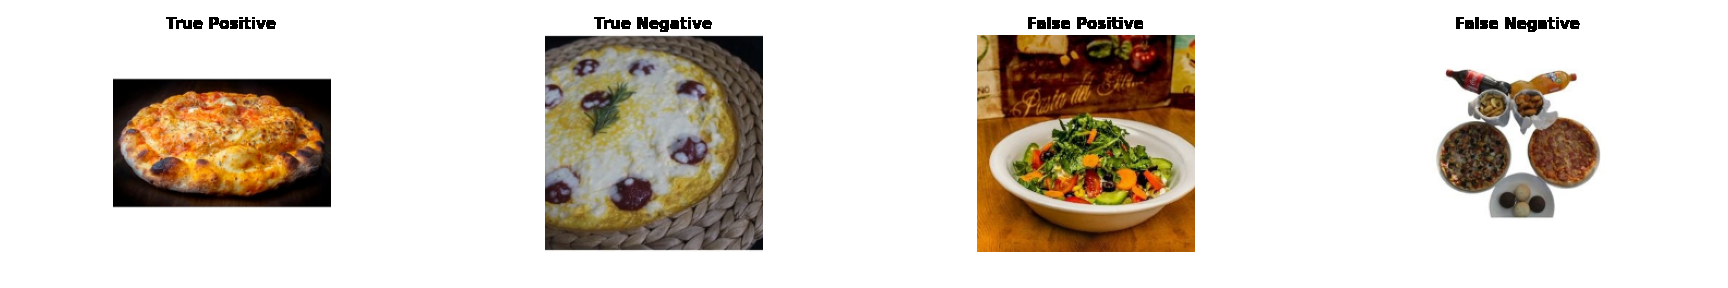

In [33]:
if(not(check_if_file_exists('images/cnn_tp.png') and check_if_file_exists('images/cnn_tn.png') and check_if_file_exists('images/cnn_fp.png') and check_if_file_exists('images/cnn_fn.png'))):
    tp, tn, fp, fn = False, False, False, False
    #test_row = 456
    #test_row = 456
    for test_row in range(len(labels_test)):
        true_label = labels_test[test_row][1].astype(np.uint8)
        prediction = round(label_prediction[test_row][1])
        if(true_label == 1 and prediction == 1 and tp == False):
            tp = test_row
            plt.title('True Positive',fontweight='bold',fontsize=15)
            plt.imshow((features_test[tp]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_tp.png')
            plt.close()
            continue
        if(true_label == 0 and prediction == 0 and tn == False):
            tn = test_row
            plt.title('True Negative',fontweight='bold',fontsize=15)
            plt.imshow((features_test[tn]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_tn.png')
            plt.close()
            continue
        if(true_label == 0 and prediction == 1 and fp == False):
            fp = test_row
            plt.title('False Positive',fontweight='bold',fontsize=15)
            plt.imshow((features_test[fp]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_fp.png')
            plt.close()
            continue
        if(true_label == 1 and prediction == 0 and fn == False):
            fn = test_row
            plt.title('False Negative',fontweight='bold',fontsize=15)
            plt.imshow((features_test[fn]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_fn.png')
            plt.close()
            continue    

images = [Image.open(x) for x in ['images/cnn_tp.png', 'images/cnn_tn.png', 'images/cnn_fp.png', 'images/cnn_fn.png']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

merged_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  merged_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

merged_im

# Sources

 1. [Selenium Documentation](https://selenium-python.readthedocs.io/)
 2. [Selenium choose element by partial id](https://stackoverflow.com/questions/15845563/choose-element-by-partial-id-using-selenium-with-python)
 3. [Selenium scroll down to end of the page](https://pythonbasics.org/selenium-scroll-down/)
 4. [Selenium click button](https://stackoverflow.com/questions/52405456/selenium-how-to-click-on-javascript-button/52405550)
 5. [Markov Chains](https://www.kaggle.com/orion99/markov-chain-nlp)
 6. [Bag of Words](https://github.com/Suji04/NormalizedNerd/blob/master/Introduction%20to%20NLP/Bag%20of%20Words%20%2B%20TF-IDF.ipynb)
 7. [Turkish Porter Stemmer](https://github.com/otuncelli/turkish-stemmer-python)
 8. [Scikit-Learn: Save & Restore Models](https://stackabuse.com/scikit-learn-save-and-restore-models)
 9. [Joblib vs Pickle](https://stackoverflow.com/questions/12615525/what-are-the-different-use-cases-of-joblib-versus-pickle)
 10. [Hide warnings in Python](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)
 11. [Slow scrolling down the page using selenium](https://stackoverflow.com/questions/30942041/slow-scrolling-down-the-page-using-selenium)
 12. [Download images using urllib](https://stackoverflow.com/questions/49627458/python-selenium-download-images-jpeg-png-or-pdf-using-chromedriver)
 13. [Saving an image to Postgres](https://stackoverflow.com/questions/16763904/how-to-save-a-image-file-on-a-postgres-database)
 14. [Convolutional Neural Networks](https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/)
 15. [Combine several images](https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python)